<a href="https://colab.research.google.com/github/ricardoV94/mbmlbook/blob/master/MBML_Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize': (8,6)})

In [0]:
try:
    import arviz
except ImportError:
    !pip install arviz
    
import logging
logger = logging.getLogger('pymc3')
logger.propagate = False
logger.setLevel(logging.ERROR)

     |████████████████████████████████| 1.3MB 2.7MB/s 
     |████████████████████████████████| 4.1MB 21.4MB/s 
     |████████████████████████████████| 307kB 42.2MB/s 




---

##  3.1 Modelling the outcome of games 

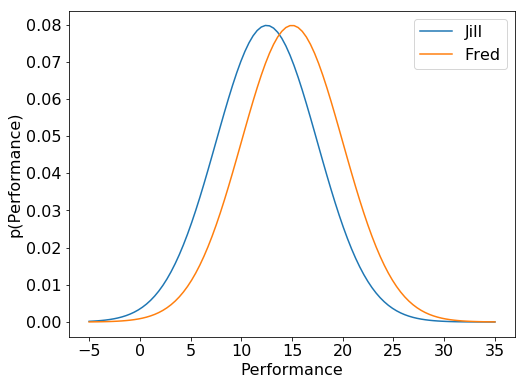

In [0]:
x = np.linspace(-5,35,100)

Jskill = 15
Fskill = 12.5
perfSD = 5

plt.plot(x, st.norm(Fskill, perfSD).pdf(x), label='Jill')
plt.plot(x, st.norm(Jskill, perfSD).pdf(x), label='Fred')

plt.ylabel('p(Performance)')
plt.xlabel('Performance')
plt.legend();

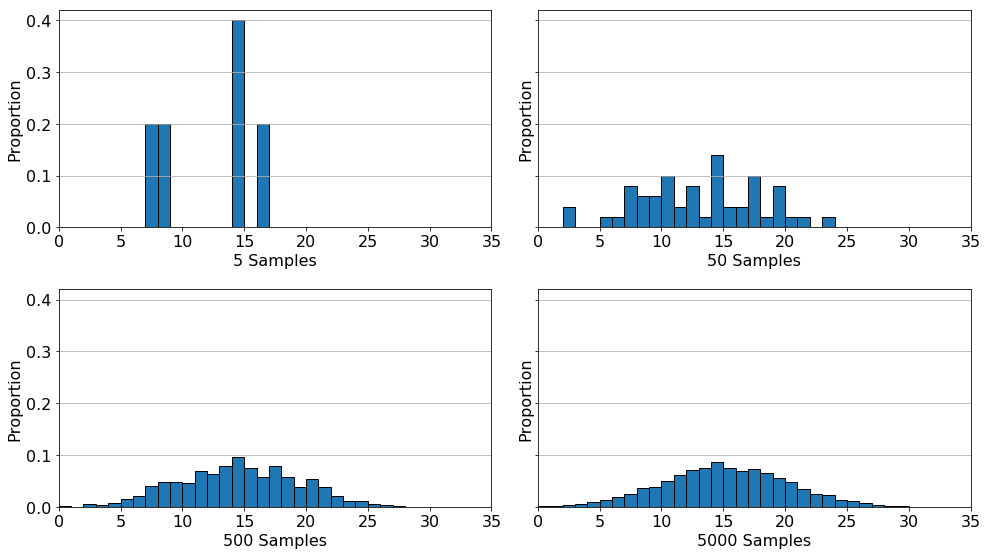

In [0]:
samples = np.random.normal(loc=15, scale=5, size=5000)

fig, ax = plt.subplots(2,2, figsize=(14,8), sharey=True)
for i, axi in enumerate(ax.ravel()):
    axi.hist(samples[:5*10**i], density=True, bins=np.arange(0,35,1), ec='k');
    axi.set_xlim([0,35])
    axi.set_xlabel(f'{5*10**i} Samples')
    axi.set_ylabel('Proportion')
    axi.grid(axis='y')
plt.tight_layout();

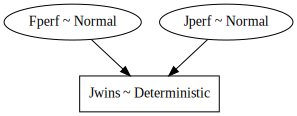

In [0]:
with pm.Model() as model1:
    Jperf = pm.Normal('Jperf', mu=Jskill, sigma=5)
    Fperf = pm.Normal('Fperf', mu=Fskill, sigma=5)
    
    Jwins = pm.Deterministic('Jwins', Jperf > Fperf)
    
pm.model_to_graphviz(model1)

In [0]:
with model1:
    sample = pm.sample_prior_predictive(samples=1000)

Text(25, 2, 'Fred Wins\n36.5%')

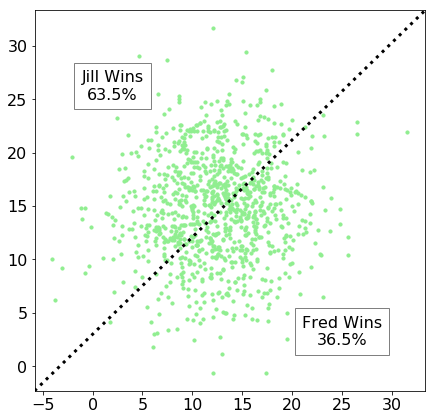

In [0]:
plt.figure(figsize=(7,7))
plt.scatter(sample['Fperf'], sample['Jperf'], c='lightgreen', s=10)
#plt.plot(np.linspace(-5,35,100), np.linspace(-5,35,100))
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, c='k', linestyle='dotted', lw=3)
plt.annotate(f"Jill Wins\n{sample['Jwins'].mean()*100:.1f}%", (2, 25), ha='center', bbox=dict(fc='w', ec='gray', pad=7))
plt.annotate(f"Fred Wins\n{(1-sample['Jwins'].mean())*100:.1f}%", (25, 2), ha='center', bbox=dict(fc='w', ec='gray', pad=7))

In [0]:
np.sqrt(50), np.sqrt(2)*5

(7.0710678118654755, 7.0710678118654755)

Text(0.8535533905932737, 0.5381631950841185, '0.638')

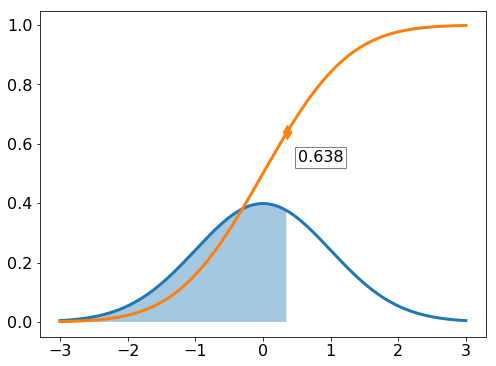

In [0]:
x = np.linspace(-3,3, 600)
y1 = st.norm(0, 1).pdf(x)
y2 = st.norm(0,1).cdf(x)

xPoint = (Jskill-Fskill)/(np.sqrt(2)*perfSD)
yPoint = st.norm(0,1).cdf(xPoint)
x_idx = int((xPoint - -3)*100)

plt.plot(x,y1, lw=3)
plt.fill_between(x[:x_idx],0,y1[:x_idx], alpha=.4)
plt.plot(x,y2, lw=3)
plt.scatter(xPoint, yPoint, marker='d', s=100)
plt.annotate(str(np.round(yPoint,3)), (xPoint+.5, yPoint-.1), ha='center', bbox=dict(fc='w', ec='gray', pad=3))

##  3.2 Inferring the players’ skills 

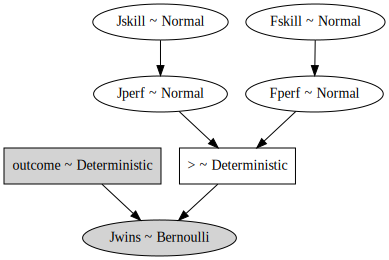

In [0]:
with pm.Model() as model2:
    outcome = pm.Data('outcome', value=1)
    
    Jskill = pm.Normal('Jskill', mu=120, sigma=40)
    Fskill = pm.Normal('Fskill', mu=100, sigma=5)
    
    Jperf = pm.Normal('Jperf', mu=Jskill, sigma=5, testval=141)
    Fperf = pm.Normal('Fperf', mu=Fskill, sigma=5)
    
    #Jperf_gt_Fperf = pm.math.switch(Jperf > Fperf, 1, 0)
    Jperf_gt_Fperf = pm.Deterministic('>', Jperf > Fperf)
    Jwins = pm.Bernoulli('Jwins', p=Jperf_gt_Fperf, observed=outcome)
    
pm.model_to_graphviz(model2)

In [0]:
with model2:
    prior = pm.sampling.sample_prior_predictive(samples=2000)

In [0]:
prior['Jperf'][prior['Jwins'] == 0].mean(), prior['Jperf'][prior['Jwins'] == 1].mean()

(74.69537237938277, 140.22544076748252)

In [0]:
#Jperf.tag.test_value = 141
print(model2.check_test_point())
print(Fperf.tag.test_value)

Jskill    -4.61
Fskill    -2.53
Jperf    -11.35
Fperf     -2.53
Jwins      0.00
Name: Log-probability of test_point, dtype: float64
100.0


In [0]:
with model2:
    post = pm.sample(draws=4000, target_accept=.95, tune=500)

100%|██████████| 4500/4500 [00:14<00:00, 313.51it/s]
There were 1739 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3578 divergences after tuning. Increase `target_accept` or reparameterize.


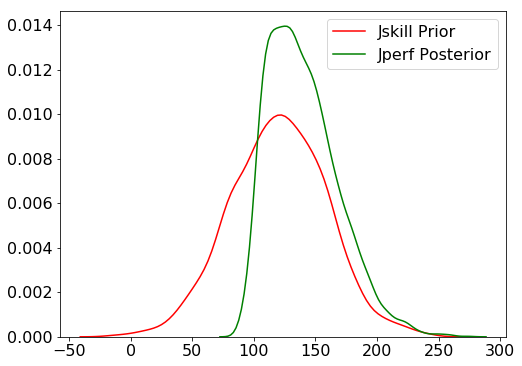

In [0]:
sns.distplot(prior['Jskill'], color='r', hist=False, label='Jskill Prior')
sns.distplot(post['Jperf'], color='g', hist=False, label='Jperf Posterior')
plt.legend()

##  3.3 A solution: expectation propagation

136.6237752786112 27.220282566408354


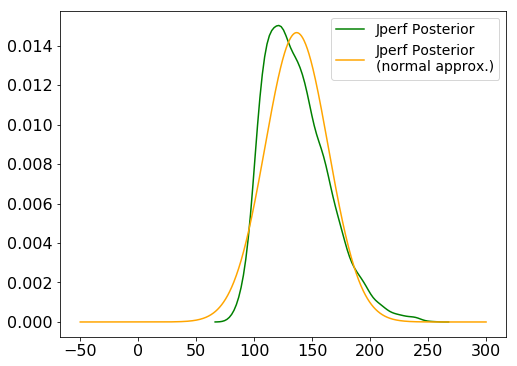

In [0]:
mu1 = post['Jperf'].mean()
sigma1 = post['Jperf'].std()
sns.distplot(post['Jperf'], color='g', hist=False, label='Jperf Posterior')

print(mu1, sigma1)
x=np.linspace(-50,300,1000)
y1=st.norm(mu1, sigma1).pdf(x)

plt.plot(x, y1, color='orange', label='Jperf Posterior\n(normal approx.)')
plt.legend(prop={'size':14});

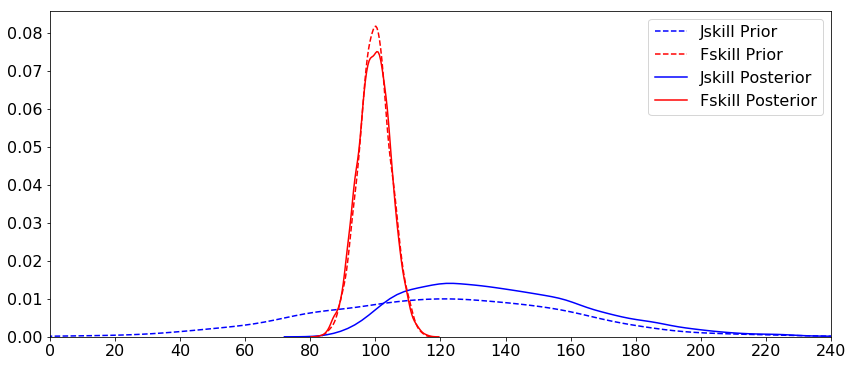

In [0]:
plt.figure(figsize=(14,6))
sns.distplot(prior['Jskill'], color='b', hist=False, label='Jskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(prior['Fskill'], color='r', hist=False, label='Fskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(post['Jskill'], color='b', hist=False, label='Jskill Posterior')
sns.distplot(post['Fskill'], color='r', hist=False, label='Fskill Posterior')
plt.xlim([0,240])
plt.xticks(np.arange(0,260,20));

In [0]:
# Alternatively
with pm.Model() as model2:
    outcome = pm.Data('outcome', value=0)
    #testval = theano.shared(75)
    
    Jskill = pm.Normal('Jskill', mu=120, sigma=40)
    Fskill = pm.Normal('Fskill', mu=100, sigma=5)
    
    Jperf = pm.Normal('Jperf', mu=Jskill, sigma=5, testval=75)
    Fperf = pm.Normal('Fperf', mu=Fskill, sigma=5)
    
    #Jperf_gt_Fperf = pm.math.switch(Jperf > Fperf, 1, 0)
    Jperf_gt_Fperf = pm.Deterministic('>', Jperf > Fperf)
    Jwins = pm.Bernoulli('Jwins', p=Jperf_gt_Fperf, observed=outcome)

In [0]:
with model2:
    post = pm.sample(draws=2000, target_accept=.99, tune=1000)

100%|██████████| 3000/3000 [00:57<00:00, 36.53it/s]
There were 1102 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2239 divergences after tuning. Increase `target_accept` or reparameterize.


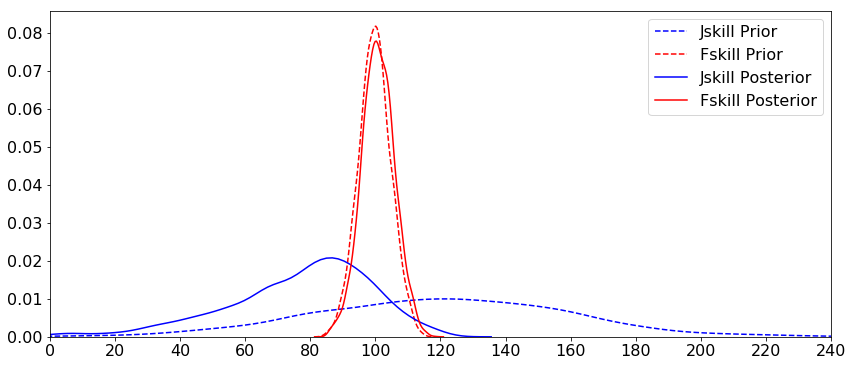

In [0]:
plt.figure(figsize=(14,6))
sns.distplot(prior['Jskill'], color='b', hist=False, label='Jskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(prior['Fskill'], color='r', hist=False, label='Fskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(post['Jskill'], color='b', hist=False, label='Jskill Posterior')
sns.distplot(post['Fskill'], color='r', hist=False, label='Fskill Posterior')
plt.xlim([0,240])
plt.xticks(np.arange(0,260,20));

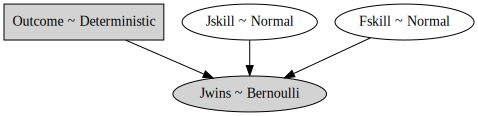

In [0]:
# Reparameterization
with pm.Model() as model3:
    outcome = pm.Data('Outcome', value=1)
    JSkill = pm.Normal('Jskill', 120., 40.)
    FSkill = pm.Normal('Fskill', 100., 5.)
    lg_p = pm.distributions.dist_math.normal_lccdf(JSkill - FSkill, pm.math.sqrt(50.), 0.)
    JWin = pm.Bernoulli('Jwins', pm.math.exp(lg_p), observed=outcome)
pm.model_to_graphviz(model3)

In [0]:
with model3:
    prior = pm.sample_prior_predictive()

In [0]:
with model3:
    outcome.set_value(1)
    post = pm.sample(draws=4000, target_accept=.9)

100%|██████████| 4500/4500 [00:05<00:00, 855.99it/s]


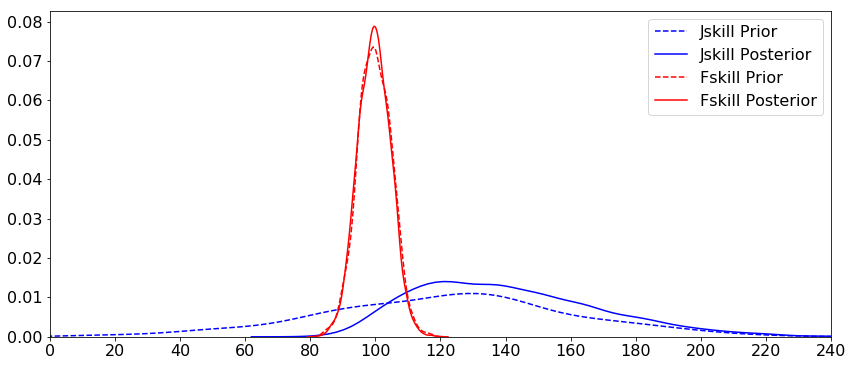

In [0]:
plt.figure(figsize=(14,6))
sns.distplot(prior['Jskill'], color='b', hist=False, label='Jskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(post['Jskill'], color='b', hist=False, label='Jskill Posterior')
sns.distplot(prior['Fskill'], color='r', hist=False, label='Fskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(post['Fskill'], color='r', hist=False, label='Fskill Posterior')
plt.xlim([0,240])
plt.xticks(np.arange(0,260,20));

In [0]:
with model3:
    outcome.set_value(0)
    post = pm.sample(draws=4000, target_accept=.9)

100%|██████████| 4500/4500 [00:05<00:00, 865.19it/s]


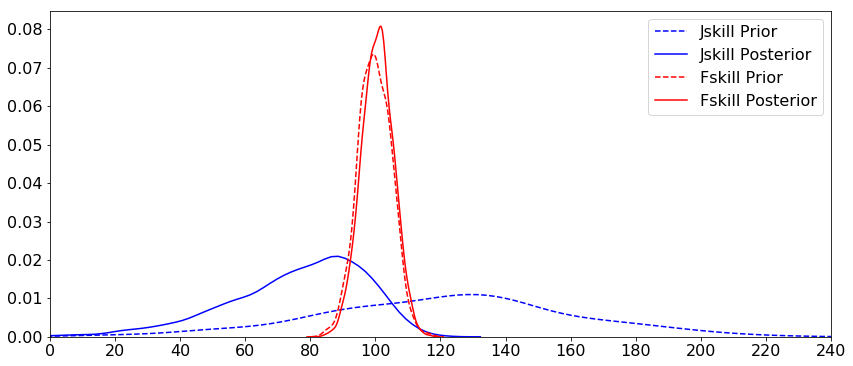

In [0]:
plt.figure(figsize=(14,6))
sns.distplot(prior['Jskill'], color='b', hist=False, label='Jskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(post['Jskill'], color='b', hist=False, label='Jskill Posterior')
sns.distplot(prior['Fskill'], color='r', hist=False, label='Fskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(post['Fskill'], color='r', hist=False, label='Fskill Posterior')
plt.xlim([0,240])
plt.xticks(np.arange(0,260,20));

## 3.4 Extensions to the core model

### More than 2 players

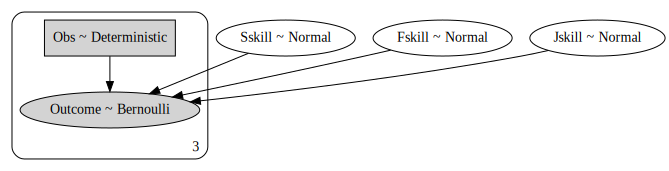

In [0]:
with pm.Model() as model4:
    obs = pm.Data('Obs', value=[1,1,1])
    JSkill = pm.Normal('Jskill', 120., 20.)
    FSkill = pm.Normal('Fskill', 100., 40.)
    SSkill = pm.Normal('Sskill', 140., 40.)
    lg_p1 = pm.distributions.dist_math.normal_lccdf(JSkill - FSkill, pm.math.sqrt(50.), 0.)
    lg_p2 = pm.distributions.dist_math.normal_lccdf(FSkill - SSkill, pm.math.sqrt(50.), 0.)
    lg_p3 = pm.distributions.dist_math.normal_lccdf(JSkill - SSkill, pm.math.sqrt(50.), 0.) # This can be avoided if nodes are ordered by outcome
    lg_p = tt.stack([lg_p1, lg_p2, lg_p3])
    outcome = pm.Bernoulli('Outcome', pm.math.exp(lg_p), shape=3, observed=obs)
pm.model_to_graphviz(model4)

In [0]:
with model4:
    obs.set_value([1,1,1]) # Jill 1st, Fred 2nd, Stever 3rd 
    prior = pm.sample_prior_predictive(samples=2000)
    post = pm.sample(draws=5000)

100%|██████████| 5500/5500 [00:11<00:00, 485.75it/s]


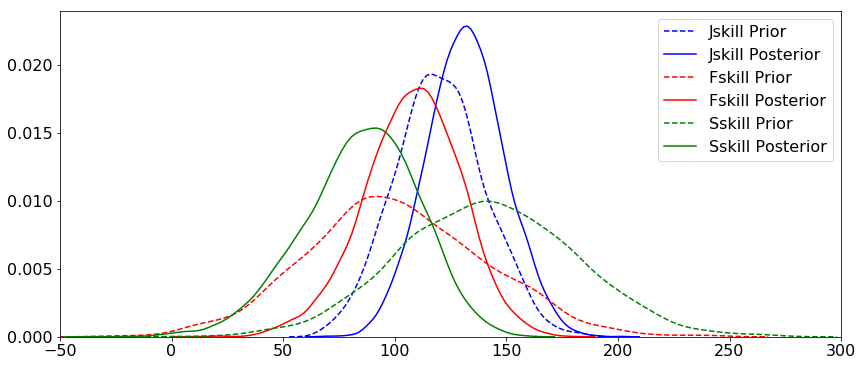

In [0]:
plt.figure(figsize=(14,6))
sns.distplot(prior['Jskill'], color='b', hist=False, label='Jskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(post['Jskill'], color='b', hist=False, label='Jskill Posterior')
sns.distplot(prior['Fskill'], color='r', hist=False, label='Fskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(post['Fskill'], color='r', hist=False, label='Fskill Posterior')
sns.distplot(prior['Sskill'], color='g', hist=False, label='Sskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(post['Sskill'], color='g', hist=False, label='Sskill Posterior')
plt.xlim([-50,300])
plt.xticks(np.arange(-50,350,50));

In [0]:
with model4:
    obs.set_value([0,1,1]) # Jill 2nd, Fred 1st, Steve 3rd
    post = pm.sample(draws=5000)

100%|██████████| 5500/5500 [00:10<00:00, 505.58it/s]


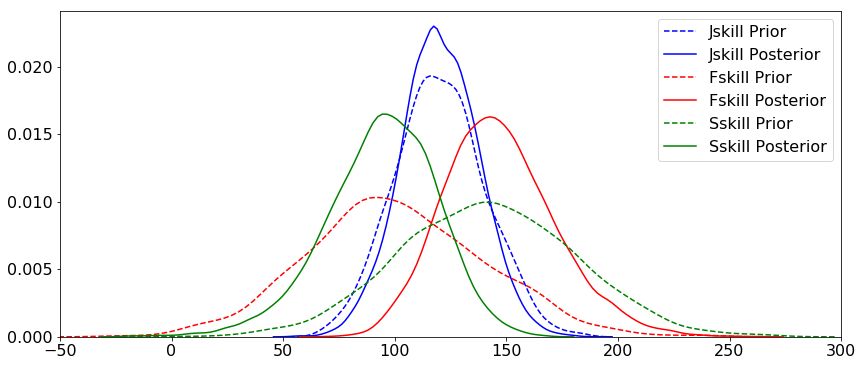

In [0]:
plt.figure(figsize=(14,6))
sns.distplot(prior['Jskill'], color='b', hist=False, label='Jskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(post['Jskill'], color='b', hist=False, label='Jskill Posterior')
sns.distplot(prior['Fskill'], color='r', hist=False, label='Fskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(post['Fskill'], color='r', hist=False, label='Fskill Posterior')
sns.distplot(prior['Sskill'], color='g', hist=False, label='Sskill Prior', kde_kws={'linestyle':'--'})
sns.distplot(post['Sskill'], color='g', hist=False, label='Sskill Posterior')
plt.xlim([-50,300])
plt.xticks(np.arange(-50,350,50));

### Teams of players

Not sure what is the correct reparameterization for teams...

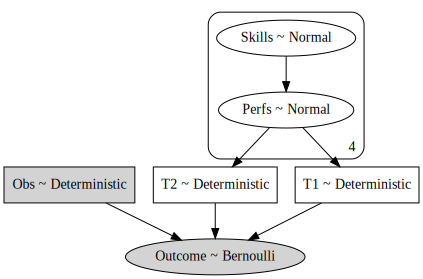

In [0]:
with pm.Model() as model5:
    obs = pm.Data('Obs', value=[1])
    Skills = pm.Normal('Skills', 120., 40., shape=4)
    Perfs = pm.Normal('Perfs', Skills, 5, shape=4)
    T1 = pm.Deterministic('T1', Perfs[0]+Perfs[1])
    T2 = pm.Deterministic('T2', Perfs[2]+Perfs[3])
    #p = pm.Deterministic('>', T1 > T2)
    
    lg_p = pm.distributions.dist_math.normal_lccdf(T1 - T2, 0.01, 0.)
    outcome = pm.Bernoulli('Outcome', pm.math.exp(lg_p), observed=obs)
    #outcome = pm.Bernoulli('Outcome', p, observed=obs)
pm.model_to_graphviz(model5)

In [0]:
with model5:
    prior=pm.sample_prior_predictive(1000)

In [0]:
with model5:
    post = pm.sample(4000)

  0%|          | 0/4500 [00:00<?, ?it/s]


SamplingError: ignored

## 3.5 Allowing the skills to vary